In [1]:
import os
import numpy as np
import h5py
import glob
import itertools
import sys
from sklearn.utils import shuffle
import glob

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

In [3]:
datasets = [np.array([]), np.array([]), np.array([]), np.array([])]
dataNames = ["genJetConstituents", "recoJetConstituents", "genJetFeatures", "recoJetFeatures"]
for fileIN in glob.glob("../data/*h5"):
    f = h5py.File(fileIN,"r")
    for i in range(4):
        mydata = f.get(dataNames[i])
        datasets[i] = np.concatenate((datasets[i], mydata), axis=0) if datasets[i].size else mydata
genJetParticles = datasets[0]
recoJetParticles = datasets[1]
genJet = datasets[2]
recoJet = datasets[3]
print(genJetParticles.shape, recoJetParticles.shape, genJet.shape, recoJet.shape)

(109984, 100, 3) (109984, 100, 3) (109984, 4) (109984, 4)


In [4]:
# add the "noisy" latent space variables to the genjet dataset
rndVars = np.random.normal(0., 1., (genJet.shape[0],10))
print(rndVars.shape)
genJet = np.concatenate((genJet,rndVars), axis =1)
print(genJet.shape)

(109984, 10)
(109984, 14)


In [102]:
nameModel = 'JetGen_EMD'

In [103]:
# import the Generator model
from keras.models import model_from_json
json_file = open('../models/%s_GENERATOR.json' %nameModel)
loaded_model_json = json_file.read()
json_file.close()
genModel = model_from_json(loaded_model_json)
# load weights into new model
genModel.load_weights("../models/%s_GENERATOR.h5" %nameModel)
print("Loaded model from disk")
for l in genModel.layers: 
    l.trainable=False
genModel.summary()

Loaded model from disk
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 14)           0                                            
__________________________________________________________________________________________________
noise1 (BatchNormalization)     (None, 14)           56          input_20[0][0]                   
__________________________________________________________________________________________________
noise2 (Dense)                  (None, 100)          1500        noise1[0][0]                     
__________________________________________________________________________________________________
noise3 (Dense)                  (None, 300)          30300       noise2[0][0]                     
______________________________________________________________________________________

In [104]:
# traininig history
history = h5py.File("../models/%s_history.h5" %nameModel)
training_loss = history.get("training_loss")
validation_loss = history.get("validation_loss")
epochs = np.array(range(len(training_loss)))

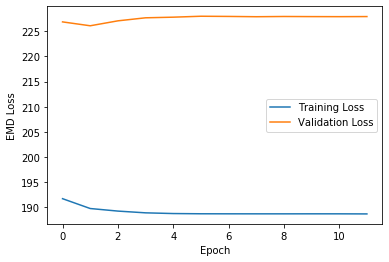

In [105]:
# compare prediction to true value
plt.plot(epochs, training_loss, label="Training Loss")
plt.plot(epochs, validation_loss, label="Validation Loss")
plt.ylabel('EMD Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [106]:
# what did we generate?
genData = genModel.predict([genJet, genJetParticles])

In [107]:
print(genData.shape)

(109984, 100, 3)


In [108]:
pTGen = np.reshape(genJetParticles[:,:,0], (genData.shape[0]*genData.shape[1],))
etaGen = np.reshape(genJetParticles[:,:,1], (genData.shape[0]*genData.shape[1],))
phiGen = np.reshape(genJetParticles[:,:,2], (genData.shape[0]*genData.shape[1],))

In [109]:
pTDFS = np.reshape(genData[:,:,0], (genData.shape[0]*genData.shape[1],))
etaDFS = np.reshape(genData[:,:,1], (genData.shape[0]*genData.shape[1],))
phiDFS = np.reshape(genData[:,:,2], (genData.shape[0]*genData.shape[1],))

In [110]:
pTTrue = np.reshape(recoJetParticles[:,:,0], (recoJetParticles.shape[0]*recoJetParticles.shape[1],))
etaTrue = np.reshape(recoJetParticles[:,:,1], (recoJetParticles.shape[0]*recoJetParticles.shape[1],))
phiTrue = np.reshape(recoJetParticles[:,:,2], (recoJetParticles.shape[0]*recoJetParticles.shape[1],))

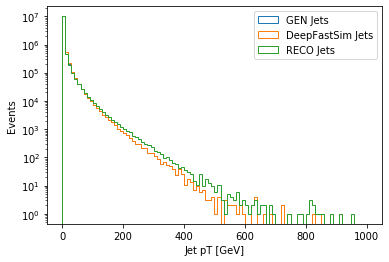

In [111]:
# compare prediction to true value
plt.hist(pTGen, range=(0., 1000.), bins=100, label="GEN Jets", histtype='step')
plt.hist(pTDFS, range=(0., 1000.), bins=100, label="DeepFastSim Jets", histtype='step')
plt.hist(pTTrue, range=(0., 1000.), bins=100, label="RECO Jets", histtype='step')
plt.ylabel('Events')
plt.xlabel('Jet pT [GeV]')
plt.semilogy()
#plt.semilogx()
plt.legend()
plt.show()

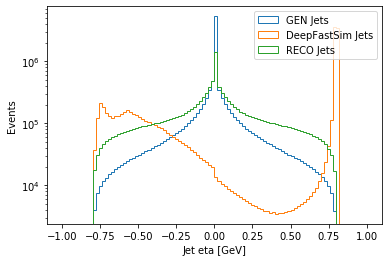

In [112]:
# compare prediction to true value
plt.hist(etaGen, range=(-1., 1.), bins=100, label="GEN Jets", histtype='step')
plt.hist(etaDFS, range=(-1., 1.), bins=100, label="DeepFastSim Jets", histtype='step')
plt.hist(etaTrue, range=(-1., 1.), bins=100, label="RECO Jets", histtype='step')
plt.ylabel('Events')
plt.xlabel('Jet eta [GeV]')
plt.semilogy()
plt.legend()
plt.show()

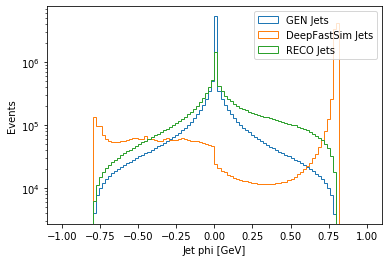

In [113]:
# compare prediction to true value
plt.hist(phiGen, range=(-1., 1.), bins=100, label="GEN Jets", histtype='step')
plt.hist(phiDFS, range=(-1., 1.), bins=100, label="DeepFastSim Jets", histtype='step')
plt.hist(phiTrue, range=(-1., 1.), bins=100, label="RECO Jets", histtype='step')
plt.ylabel('Events')
plt.xlabel('Jet phi [GeV]')
plt.semilogy()
plt.legend()
plt.show()

In [87]:
nameModel = 'JetGen_MAE'

In [88]:
# import the Generator model
from keras.models import model_from_json
json_file = open('../models/%s_GENERATOR.json' %nameModel)
loaded_model_json = json_file.read()
json_file.close()
genModel = model_from_json(loaded_model_json)
# load weights into new model
genModel.load_weights("../models/%s_GENERATOR.h5" %nameModel)
print("Loaded model from disk")
for l in genModel.layers: 
    l.trainable=False
genModel.summary()

Loaded model from disk
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 14)           0                                            
__________________________________________________________________________________________________
noise1 (BatchNormalization)     (None, 14)           56          input_20[0][0]                   
__________________________________________________________________________________________________
noise2 (Dense)                  (None, 100)          1500        noise1[0][0]                     
__________________________________________________________________________________________________
noise3 (Dense)                  (None, 300)          30300       noise2[0][0]                     
______________________________________________________________________________________

In [89]:
# traininig history
history = h5py.File("../models/%s_history.h5" %nameModel)
training_loss = history.get("training_loss")
validation_loss = history.get("validation_loss")
epochs = np.array(range(len(training_loss)))

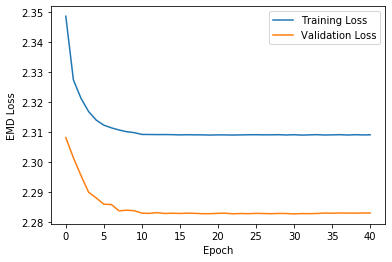

In [90]:
# compare prediction to true value
plt.plot(epochs, training_loss, label="Training Loss")
plt.plot(epochs, validation_loss, label="Validation Loss")
plt.ylabel('EMD Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [91]:
# what did we generate?
genData = genModel.predict([genJet, genJetParticles])

In [92]:
pTGen = np.reshape(genJetParticles[:,:,0], (genData.shape[0]*genData.shape[1],))
etaGen = np.reshape(genJetParticles[:,:,1], (genData.shape[0]*genData.shape[1],))
phiGen = np.reshape(genJetParticles[:,:,2], (genData.shape[0]*genData.shape[1],))

In [93]:
pTDFS = np.reshape(genData[:,:,0], (genData.shape[0]*genData.shape[1],))
etaDFS = np.reshape(genData[:,:,1], (genData.shape[0]*genData.shape[1],))
phiDFS = np.reshape(genData[:,:,2], (genData.shape[0]*genData.shape[1],))

In [94]:
pTTrue = np.reshape(recoJetParticles[:,:,0], (recoJetParticles.shape[0]*recoJetParticles.shape[1],))
etaTrue = np.reshape(recoJetParticles[:,:,1], (recoJetParticles.shape[0]*recoJetParticles.shape[1],))
phiTrue = np.reshape(recoJetParticles[:,:,2], (recoJetParticles.shape[0]*recoJetParticles.shape[1],))

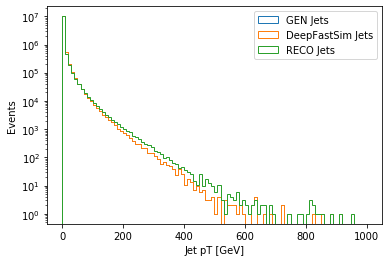

In [101]:
# compare prediction to true value
plt.hist(pTGen, range=(0., 1000.), bins=100, label="GEN Jets", histtype='step')
plt.hist(pTDFS, range=(0., 1000.), bins=100, label="DeepFastSim Jets", histtype='step')
plt.hist(pTTrue, range=(0., 1000.), bins=100, label="RECO Jets", histtype='step')
plt.ylabel('Events')
plt.xlabel('Jet pT [GeV]')
plt.semilogy()
#plt.semilogx()
plt.legend()
plt.show()

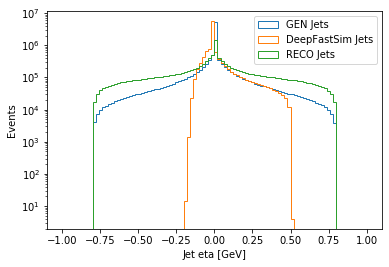

In [96]:
# compare prediction to true value
plt.hist(etaGen, range=(-1., 1.), bins=100, label="GEN Jets", histtype='step')
plt.hist(etaDFS, range=(-1., 1.), bins=100, label="DeepFastSim Jets", histtype='step')
plt.hist(etaTrue, range=(-1., 1.), bins=100, label="RECO Jets", histtype='step')
plt.ylabel('Events')
plt.xlabel('Jet eta [GeV]')
plt.semilogy()
plt.legend()
plt.show()

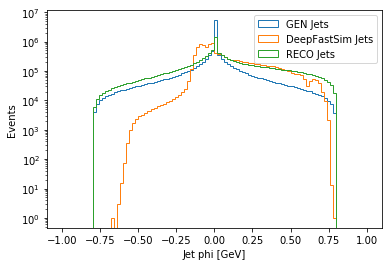

In [97]:
# compare prediction to true value
plt.hist(phiGen, range=(-1., 1.), bins=100, label="GEN Jets", histtype='step')
plt.hist(phiDFS, range=(-1., 1.), bins=100, label="DeepFastSim Jets", histtype='step')
plt.hist(phiTrue, range=(-1., 1.), bins=100, label="RECO Jets", histtype='step')
plt.ylabel('Events')
plt.xlabel('Jet phi [GeV]')
plt.semilogy()
plt.legend()
plt.show()